In [69]:
import yfinance as yf
import pandas as pd
import os
import numpy as np
import mplfinance as mpf
import matplotlib.dates as mpl_dates 

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
%matplotlib inline

from keras.layers import Dense, LSTM, Dropout
from keras.regularizers import l2
from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import warnings
warnings.filterwarnings("ignore")

In [70]:
# Download the data (For local use)
def get_stock_data(name, start_date, end_date):
    stock = yf.Ticker(name)

    df = stock.history(start=start_date, end=end_date)
    df = df.reset_index()
    
    return df

names = ["MSFT", "GOOG", "AAPL", "AMZN", "NVDA", "META"]
start_date = "2014-06-30"
end_date = "2024-06-30"

for name in names:
    df = get_stock_data(name, start_date, end_date)

    path = os.path.abspath(f"../data/{name.lower()}_stock_data.csv")
    df.to_csv(path, index=False)
    print(f"Data saved to {path}")


Data saved to d:\Files\Projects\stockMarketAnalysisAndPrediction\data\msft_stock_data.csv
Data saved to d:\Files\Projects\stockMarketAnalysisAndPrediction\data\goog_stock_data.csv
Data saved to d:\Files\Projects\stockMarketAnalysisAndPrediction\data\aapl_stock_data.csv
Data saved to d:\Files\Projects\stockMarketAnalysisAndPrediction\data\amzn_stock_data.csv
Data saved to d:\Files\Projects\stockMarketAnalysisAndPrediction\data\nvda_stock_data.csv
Data saved to d:\Files\Projects\stockMarketAnalysisAndPrediction\data\meta_stock_data.csv


In [71]:
# Download the data
names = ["MSFT", "GOOG", "AAPL", "AMZN", "META", "NVDA"]
start_date = "2014-08-01"
end_date = "2024-08-01"

stock = yf.Tickers(names)

df = stock.history(start=start_date, end=end_date)
df

[*********************100%%**********************]  6 of 6 completed


Price            Close                                                  \
Ticker            AAPL        AMZN        GOOG        META        MSFT   
Date                                                                     
2014-08-01   21.257595   15.353000   28.193922   72.211617   36.484303   
2014-08-04   21.138178   15.682500   28.546553   73.359253   36.918430   
2014-08-05   21.034250   15.616000   28.144115   72.540939   36.671570   
2014-08-06   20.998869   15.694500   28.209063   72.321381   36.382133   
2014-08-07   20.996645   15.572500   28.058947   73.019943   36.799255   
...                ...         ...         ...         ...         ...   
2024-07-25  217.490005  179.850006  169.160004  453.410004  418.399994   
2024-07-26  217.960007  182.500000  168.679993  465.700012  425.269989   
2024-07-29  218.240005  183.199997  171.130005  465.709991  426.730011   
2024-07-30  218.800003  181.710007  171.860001  463.190002  422.920013   
2024-07-31  222.080002  186.979996  173.149994  474.829987  418.350006   

Price                  Dividends                 ... Stock Splits            \
Ticker            NVDA      AAPL AMZN GOOG META  ...         GOOG META MSFT   
Date                                             ...                          
2014-08-01    0.420994    0.0000  0.0  0.0  0.0  ...          0.0  0.0  0.0   
2014-08-04    0.420042    0.0000  0.0  0.0  0.0  ...          0.0  0.0  0.0   
2014-08-05    0.420280    0.0000  0.0  0.0  0.0  ...          0.0  0.0  0.0   
2014-08-06    0.419805    0.0000  0.0  0.0  0.0  ...          0.0  0.0  0.0   
2014-08-07    0.415521    0.1175  0.0  0.0  0.0  ...          0.0  0.0  0.0   
...                ...       ...  ...  ...  ...  ...          ...  ...  ...   
2024-07-25  112.279999    0.0000  0.0  0.0  0.0  ...          0.0  0.0  0.0   
2024-07-26  113.059998    0.0000  0.0  0.0  0.0  ...          0.0  0.0  0.0   
2024-07-29  111.589996    0.0000  0.0  0.0  0.0  ...          0.0  0.0  0.0   
2024-07-30  103.730003    0.0000  0.0  0.0  0.0  ...          0.0  0.0  0.0   
2024-07-31  117.019997    0.0000  0.0  0.0  0.0  ...          0.0  0.0  0.0   

Price               Volume                                                      
Ticker     NVDA       AAPL       AMZN      GOOG      META      MSFT       NVDA  
Date                                                                            
2014-08-01  0.0  194044000  148830000  39105069  43535000  31170300  219884000  
2014-08-04  0.0  159832000   84018000  28546159  30777000  34277400  241724000  
2014-08-05  0.0  223732000   57042000  31024946  34986000  26266400  298136000  
2014-08-06  0.0  154232000   45938000  26687069  30986000  24634000  223456000  
2014-08-07  0.0  186844000   58712000  22218835  38141000  30314900  407696000  
...         ...        ...        ...       ...       ...       ...        ...  
2024-07-25  0.0   51391200   44464200  28967900  18240500  29943800  460067000  
2024-07-26  0.0   41601300   29506000  25150100  14222400  23583800  293399100  
2024-07-29  0.0   36311800   33270100  13768900  11339600  15125800  248152100  
2024-07-30  0.0   41643800   39508600  13681400  11390400  32687600  486833300  
2024-07-31  0.0   50036300   41667300  15650200  24285800  42891400  473174200  

[2516 rows x 42 columns]

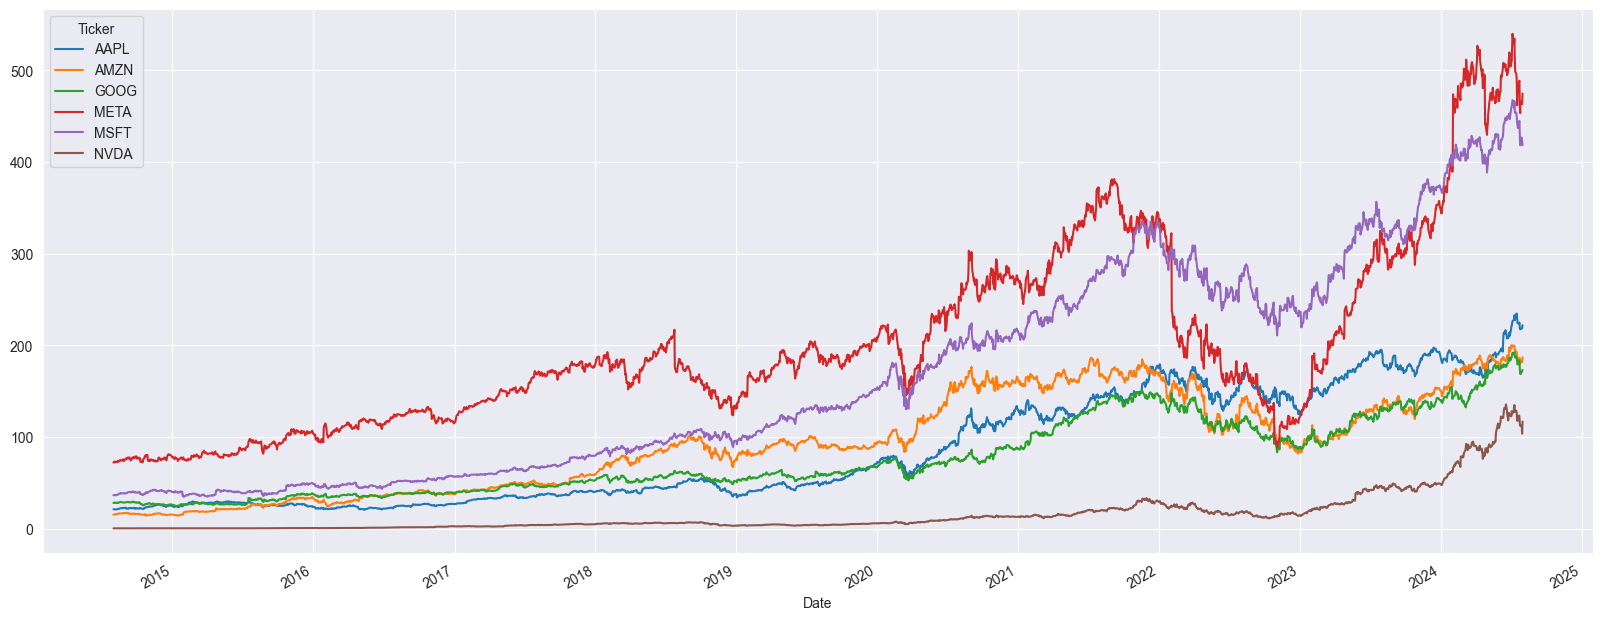

In [72]:
df["Close"].plot(figsize=(20, 8))
plt.show()

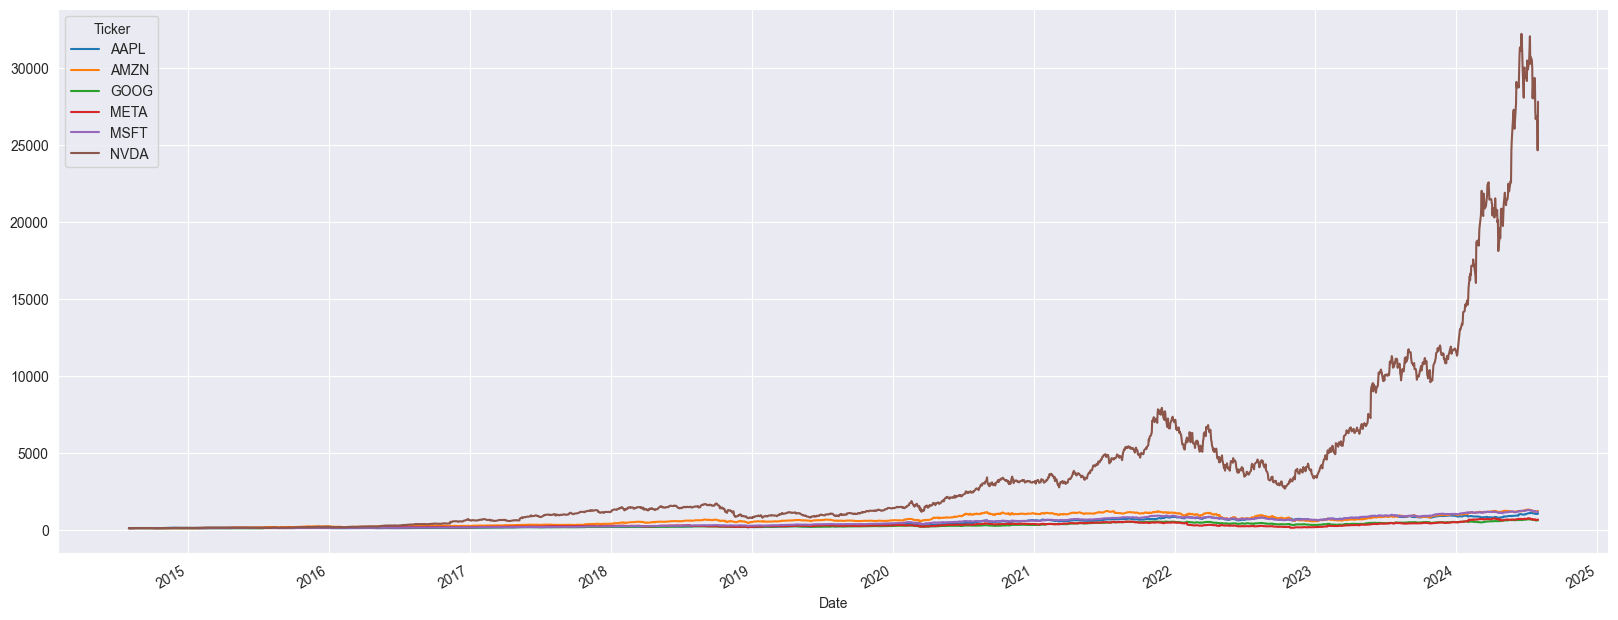

In [73]:
# normalizing the data
temp = df["Close"]
normalized_data = temp.div(temp.iloc[0]).multiply(100)
normalized_data.plot(figsize=(20, 8))
plt.show()

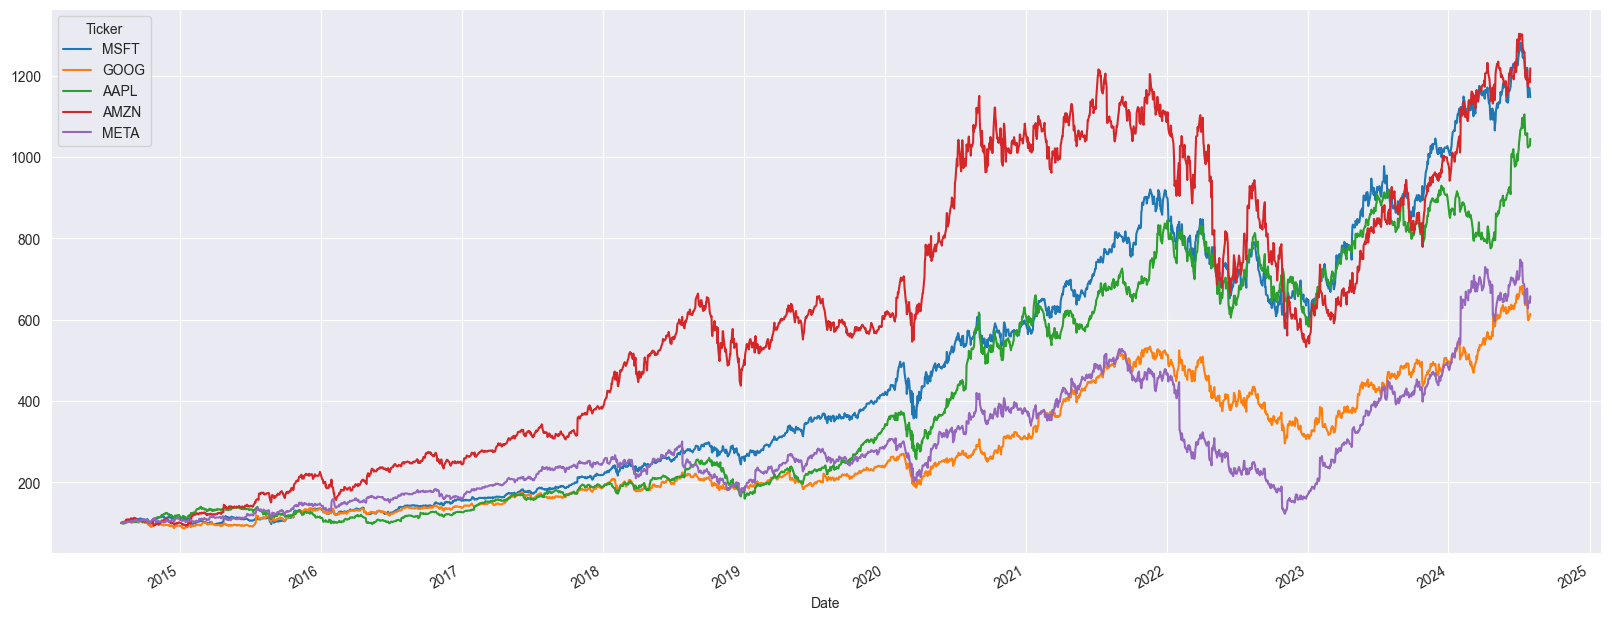

In [74]:
# normalized plot except Nvidia
temp = df["Close"][["MSFT", "GOOG", "AAPL", "AMZN", "META"]]
normalized_data = temp.div(temp.iloc[0]).multiply(100)
normalized_data.plot(figsize=(20, 8))
plt.show()

This shows Nvidia has performed the best over the past 5 years compared to all other companies followed by Amazon while Microsoft and Apple having a close perfomance later followed by Google and Meta.

In [75]:
# Calculate daily return for each stock
daily_returns = pd.DataFrame(index=df.index)

for company in names:
    daily_returns[('daily_return', company)] = df['Close'][company].pct_change()

df = pd.concat([df, daily_returns], axis=1)
df = df.sort_index(axis=1)
df = df.fillna(0)
df

Close                                                  \
                  AAPL        AMZN        GOOG        META        MSFT   
Date                                                                     
2014-08-01   21.257595   15.353000   28.193922   72.211617   36.484303   
2014-08-04   21.138178   15.682500   28.546553   73.359253   36.918430   
2014-08-05   21.034250   15.616000   28.144115   72.540939   36.671570   
2014-08-06   20.998869   15.694500   28.209063   72.321381   36.382133   
2014-08-07   20.996645   15.572500   28.058947   73.019943   36.799255   
...                ...         ...         ...         ...         ...   
2024-07-25  217.490005  179.850006  169.160004  453.410004  418.399994   
2024-07-26  217.960007  182.500000  168.679993  465.700012  425.269989   
2024-07-29  218.240005  183.199997  171.130005  465.709991  426.730011   
2024-07-30  218.800003  181.710007  171.860001  463.190002  422.920013   
2024-07-31  222.080002  186.979996  173.149994  474.829987  418.350006   

                       Dividends                 ...    Volume            \
                  NVDA      AAPL AMZN GOOG META  ...      GOOG      META   
Date                                             ...                       
2014-08-01    0.420994    0.0000  0.0  0.0  0.0  ...  39105069  43535000   
2014-08-04    0.420042    0.0000  0.0  0.0  0.0  ...  28546159  30777000   
2014-08-05    0.420280    0.0000  0.0  0.0  0.0  ...  31024946  34986000   
2014-08-06    0.419805    0.0000  0.0  0.0  0.0  ...  26687069  30986000   
2014-08-07    0.415521    0.1175  0.0  0.0  0.0  ...  22218835  38141000   
...                ...       ...  ...  ...  ...  ...       ...       ...   
2024-07-25  112.279999    0.0000  0.0  0.0  0.0  ...  28967900  18240500   
2024-07-26  113.059998    0.0000  0.0  0.0  0.0  ...  25150100  14222400   
2024-07-29  111.589996    0.0000  0.0  0.0  0.0  ...  13768900  11339600   
2024-07-30  103.730003    0.0000  0.0  0.0  0.0  ...  13681400  11390400   
2024-07-31  117.019997    0.0000  0.0  0.0  0.0  ...  15650200  24285800   

                                daily_return                                \
                MSFT       NVDA         AAPL      AMZN      GOOG      META   
Date                                                                         
2014-08-01  31170300  219884000     0.000000  0.000000  0.000000  0.000000   
2014-08-04  34277400  241724000    -0.005618  0.021462  0.012507  0.015893   
2014-08-05  26266400  298136000    -0.004917 -0.004240 -0.014098 -0.011155   
2014-08-06  24634000  223456000    -0.001682  0.005027  0.002308 -0.003027   
2014-08-07  30314900  407696000    -0.000106 -0.007773 -0.005322  0.009659   
...              ...        ...          ...       ...       ...       ...   
2024-07-25  29943800  460067000    -0.004805 -0.005419 -0.029879 -0.017040   
2024-07-26  23583800  293399100     0.002161  0.014734 -0.002838  0.027106   
2024-07-29  15125800  248152100     0.001285  0.003836  0.014525  0.000021   
2024-07-30  32687600  486833300     0.002566 -0.008133  0.004266 -0.005411   
2024-07-31  42891400  473174200     0.014991  0.029002  0.007506  0.025130   

                                
                MSFT      NVDA  
Date                            
2014-08-01  0.000000  0.000000  
2014-08-04  0.011899 -0.002261  
2014-08-05 -0.006687  0.000566  
2014-08-06 -0.007893 -0.001132  
2014-08-07  0.011465 -0.010204  
...              ...       ...  
2024-07-25 -0.024481 -0.017243  
2024-07-26  0.016420  0.006947  
2024-07-29  0.003433 -0.013002  
2024-07-30 -0.008928 -0.070436  
2024-07-31 -0.010806  0.128121  

[2516 rows x 48 columns]

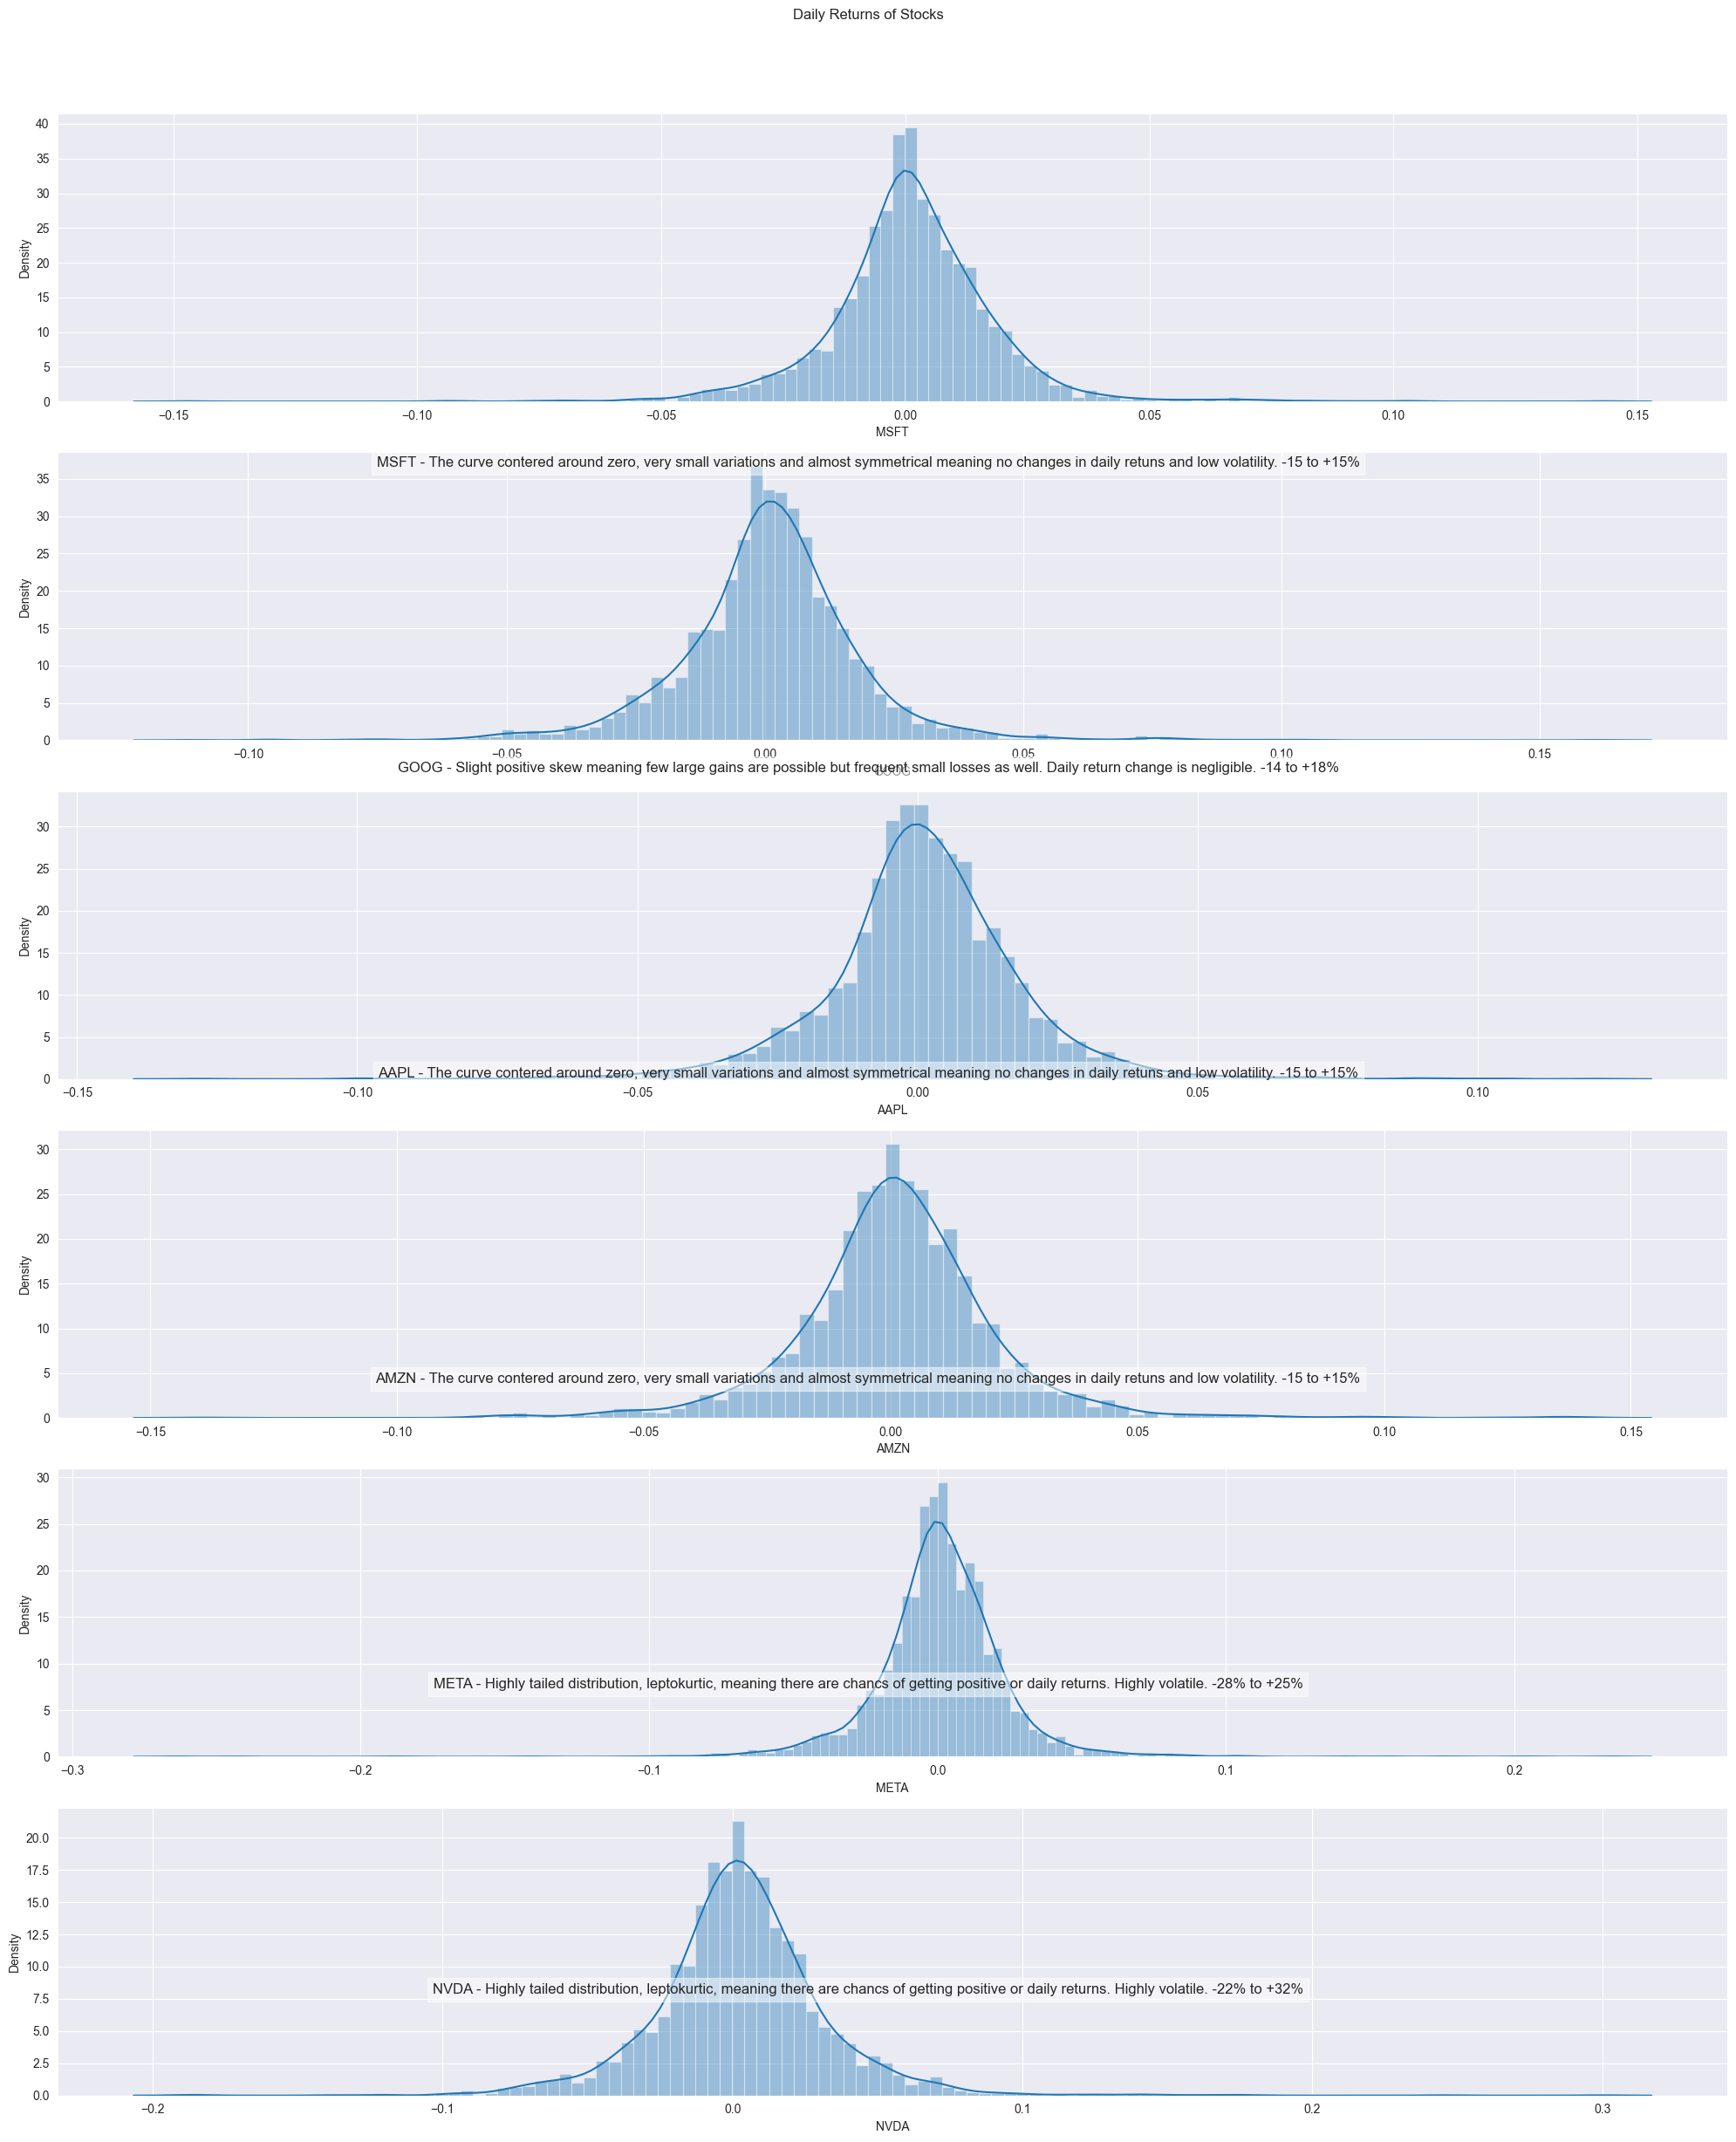

In [76]:
fig, axes = plt.subplots(6, 1, figsize=(20, 25))
fig.suptitle('Daily Returns of Stocks')

description = {"MSFT": "MSFT - The curve contered around zero, very small variations and almost symmetrical meaning no changes in daily retuns and low volatility. -15 to +15%",
               "GOOG": "GOOG - Slight positive skew meaning few large gains are possible but frequent small losses as well. Daily return change is negligible. -14 to +18%" ,
               "AAPL": "AAPL - The curve contered around zero, very small variations and almost symmetrical meaning no changes in daily retuns and low volatility. -15 to +15%",
               "AMZN": "AMZN - The curve contered around zero, very small variations and almost symmetrical meaning no changes in daily retuns and low volatility. -15 to +15%",
               "META": "META - Highly tailed distribution, leptokurtic, meaning there are chancs of getting positive or daily returns. Highly volatile. -28% to +25%",
               "NVDA": "NVDA - Highly tailed distribution, leptokurtic, meaning there are chancs of getting positive or daily returns. Highly volatile. -22% to +32%"}

for i, j in zip(names, [0, 1, 2, 3, 4, 5]):
    sns.histplot(
    df["daily_return"][i], kde=True,
    stat="density", kde_kws=dict(cut=3),
    alpha=.4, edgecolor=(1, 1, 1, .4), ax=axes[j]
    )
    # axes[j].text(0.05, 0.85, , transform=axes[j].transAxes,
                #  fontsize=12, verticalalignment='bottom', bbox=dict(facecolor='white', alpha=0.5))
    fig.text(0.5, (0.77 - j * 0.14), description[i] ,ha='center', fontsize=12, bbox=dict(facecolor='white', alpha=0.5))
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

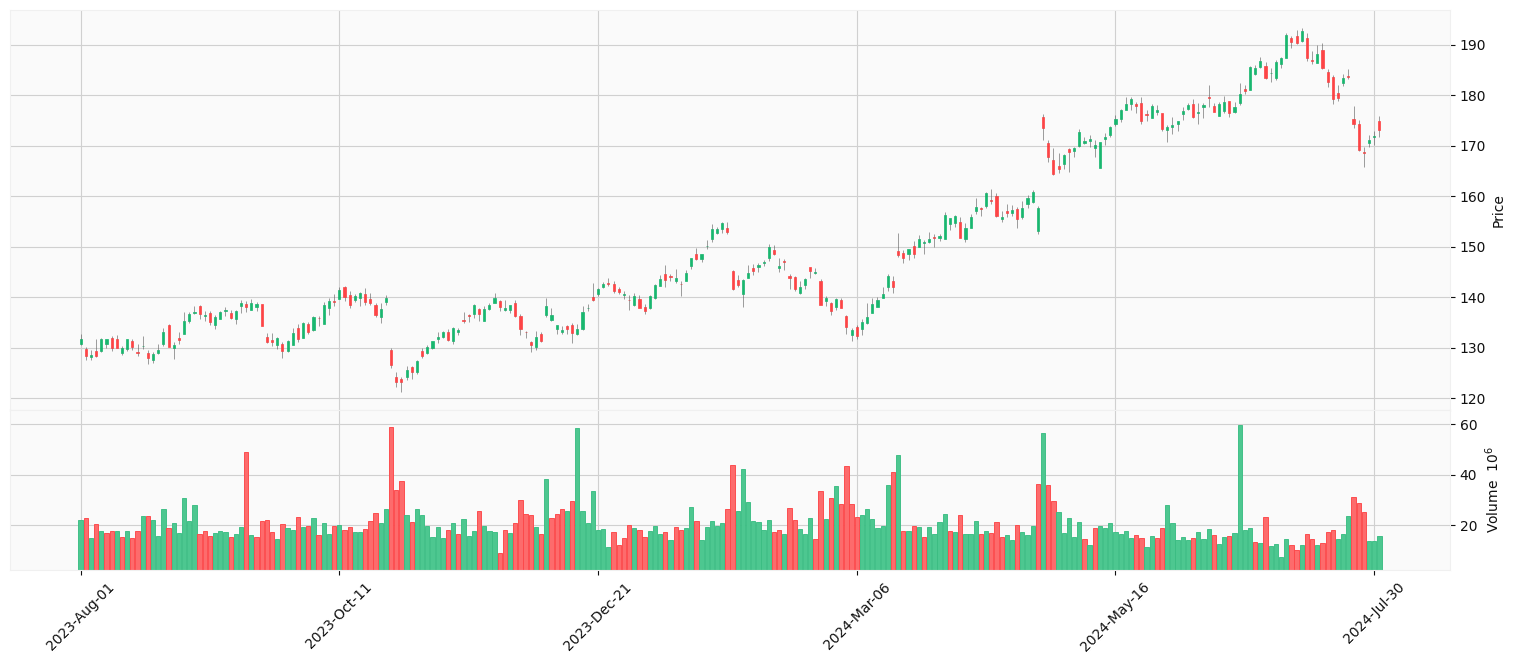

In [77]:
# Example of candle stick chart for 1 year of Google stock data
start_date = "2023-08-01"
end_date = "2024-08-01"

stock = yf.Ticker("GOOG")
temp = stock.history(start=start_date, end=end_date)
mpf.plot(temp, type='candle', style='yahoo', volume=True, figsize=(20, 8))

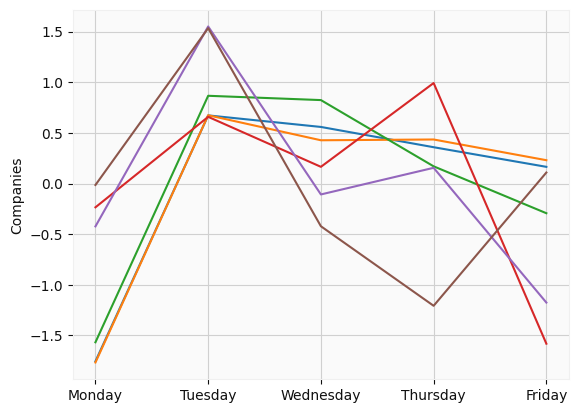

In [78]:
# normalized plot of mean closing prices of stocks on each day of the week
df["Weekday"] = df.index.dayofweek
temp = df[["Close", "Weekday"]].set_index(["Weekday"])
temp = temp.groupby("Weekday").mean().reset_index()
normalized_df = (temp - temp.mean()) / (temp.std())
days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]

fig, axes = plt.subplots(1, 1)
for i in names:
    axes.plot(days, normalized_df["Close"][i])


plt.ylabel("Companies")
plt.show()


From this chart,                                                                 
Green - AAPL, GOOG - Orange, MSFT - Blue, NVDA - Brown, META - Purple, AMZN - Red
| Company     | Best to buy stocks on | Best to sell stocks on |
| ----------- | --------------------- | ---------------------- |
| Google      | Monday                | Tuesday                |
| Microsoft   | Monday                | Tuesday                |
| Nvidia      | Thursday              | Tuesday                |
| Amazon      | Friday                | Thursday               |
| Meta        | Friday                | Tuesday                |
| Apple       | Monday                | Tuesday                |

From this trend we can say that it is best to buy stocks on Monday and Fridays whereas it i best to sell stocks on Tuesdays.

In [79]:
#Creating new dataframe for the closing prices and converting to daily returns
close_df = df["Close"]
close_df = close_df
close_df = close_df.pct_change()
close_df

,AAPL,AMZN,GOOG,META,MSFT,NVDA
Date,,,,,,
2014-08-01,NaN,NaN,NaN,NaN,NaN,NaN
2014-08-04,-0.005618,0.021462,0.012507,0.015893,0.011899,-0.002261
2014-08-05,-0.004917,-0.004240,-0.014098,-0.011155,-0.006687,0.000566
2014-08-06,-0.001682,0.005027,0.002308,-0.003027,-0.007893,-0.001132
2014-08-07,-0.000106,-0.007773,-0.005322,0.009659,0.011465,-0.010204
...,...,...,...,...,...,...
2024-07-25,-0.004805,-0.005419,-0.029879,-0.017040,-0.024481,-0.017243
2024-07-26,0.002161,0.014734,-0.002838,0.027106,0.016420,0.006947
2024-07-29,0.001285,0.003836,0.014525,0.000021,0.003433,-0.013002


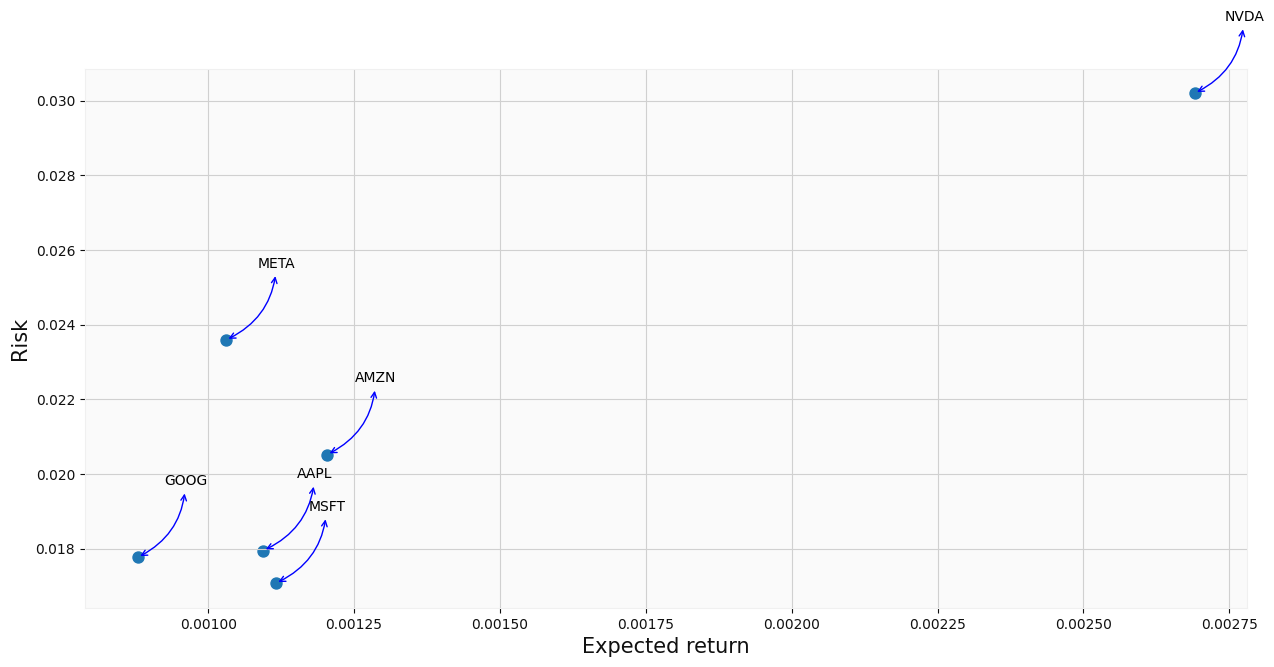

In [80]:
#Plot showing risk against expected return
plt.figure(figsize=(15, 7))
plt.scatter(close_df.dropna().mean(), close_df.dropna().std(), s=np.pi * 20)
plt.xlabel('Expected return', size=15)
plt.ylabel('Risk', size=15)
for (label, x, y) in zip(close_df.columns, close_df.dropna().mean(), close_df.dropna().std()):
    plt.annotate(label, xy=(x, y), xytext=(50, 50), textcoords='offset points', ha='right', va='bottom', 
                 arrowprops=dict(arrowstyle='<->', color='blue', connectionstyle='arc3,rad=-0.3'))

This plot shows expectee return vs the risk involved.
| Company     | Risk    | Expected Return |
| ----------- | ------- | --------------- |
| Google      | Low  | Low                |
| Microsoft   | Low     | Low-medium                |
| Nvidia      | Very High    | Very High                |
| Amazon      | low-medium | low-medium               |
| Meta        | Medium       | Low                |
| Apple       | Low       | low                |

From this, we can infer the following:                                                  
- Nvidia has high volatility / Risk but is highly rewarding. This also confirms the previous analysis also.                                       
- Apple and Microsoft has low-medium returns but comes with very low risk.                                              
- Google is having low return and very low risk as well meaning it is stable with its stock price.                                           
- Meta has low retunr but comes with medium risks, this also reconfirms the skewed data before.                                     
- Amazon has low returns and comes with low-medium risk.                                             

LSTM - Model training and testing

In [81]:
results = {}

emas = [10, 50, 200]
data_sizes = [0.5, 0.75, 1]

# Loop through the stocks
for stock in names:

    # Loop throught the data sizes
    for data_size in data_sizes:

        # Loop through the ema windows
        for ema in emas:

            # Get the data
            temp = df.copy()
            temp = temp["Close"][stock].reset_index().rename(columns={stock: "Close"})
            temp = temp[int(len(temp) * (1 - data_size)):]
            temp["ema"] = temp['Close'].ewm(span=ema, adjust=False).mean()

            data = temp
            training_data_len = int(np.ceil(len(data[["Close"]]) * .95))
            dataset = data[["Close"]].values

            #Scale the data
            sc = MinMaxScaler(feature_range=(0,1))
            scaled_data = sc.fit_transform(data[["Close"]])

            #Create the training data set
            train = scaled_data[0:int(training_data_len), :]
            x_train = []
            y_train = []

            for i in range(60, len(train)):
                x_train.append(train[i-60:i, 0])
                y_train.append(train[i, 0])
                    
            # Convert the x_train and y_train to numpy arrays and reshape the data
            x_train, y_train = np.array(x_train), np.array(y_train)
            x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

            # Create the testing data set
            test_data = scaled_data[training_data_len - 60: , :]
            x_test = []
            y_test = dataset[training_data_len:, :]

            for i in range(60, len(test_data)):
                x_test.append(test_data[i-60:i, 0])
                
            # Convert the data to a numpy array and reshape the data
            x_test = np.array(x_test)
            x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

            #Create the model
            model = Sequential()
            model = Sequential([
                LSTM(128, activation='relu', input_shape=(x_train.shape[1], 1),
                    kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01)),
                Dropout(0.2),
                Dense(1)
            ])

            # Compile and train the model and make predictions
            model.compile(optimizer='adam', loss='mean_squared_error')
            model.fit(x_train, y_train, batch_size=1, epochs=1)

            pred = model.predict(x_test)
            pred = sc.inverse_transform(pred)

            train = data[:training_data_len]
            test = data[training_data_len:]
            test['Predictions'] = pred

            if stock in results.keys():
                if mean_squared_error(test.Close, test.Predictions, squared=False) < results[stock]["error"]:
                    # print(mean_squared_error(test.Close, test.Predictions, squared=False))
                    results[stock] = {"error": mean_squared_error(test.Close, test.Predictions, squared=False), "data_test": test, "data_train": train, "best_model": f"{data_size}_{ema}"}
            else:
                # print(mean_squared_error(test.Close, test.Predictions, squared=False))
                results[stock] = {"error": mean_squared_error(test.Close, test.Predictions, squared=False), "data_test": test, "data_train": train, "best_model": f"{data_size}_{ema}"}

1136/1136 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step - loss: 0.1633
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
1136/1136 ━━━━━━━━━━━━━━━━━━━━ 26s 19ms/step - loss: 0.1613
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 315ms/step
1136/1136 ━━━━━━━━━━━━━━━━━━━━ 23s 18ms/step - loss: 0.1695
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/stepWARNING:tensorflow:6 out of the last 6 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000001C909E3BA60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/functi

Stock: MSFT, RMSE(Root Mean Squared Error) : 8.399796570052334, Best model: 1_10
Stock: GOOG, RMSE(Root Mean Squared Error) : 5.2115558551647085, Best model: 1_50
Stock: AAPL, RMSE(Root Mean Squared Error) : 6.039781140776676, Best model: 1_200
Stock: AMZN, RMSE(Root Mean Squared Error) : 4.597254874115071, Best model: 0.5_200
Stock: META, RMSE(Root Mean Squared Error) : 19.313852902226373, Best model: 0.75_50
Stock: NVDA, RMSE(Root Mean Squared Error) : 8.85471658849688, Best model: 0.75_10
Best model - 0.5, 0.75 and 1 represent size of dataset in percentages. 10, 50 and 200 represent window size of ema.


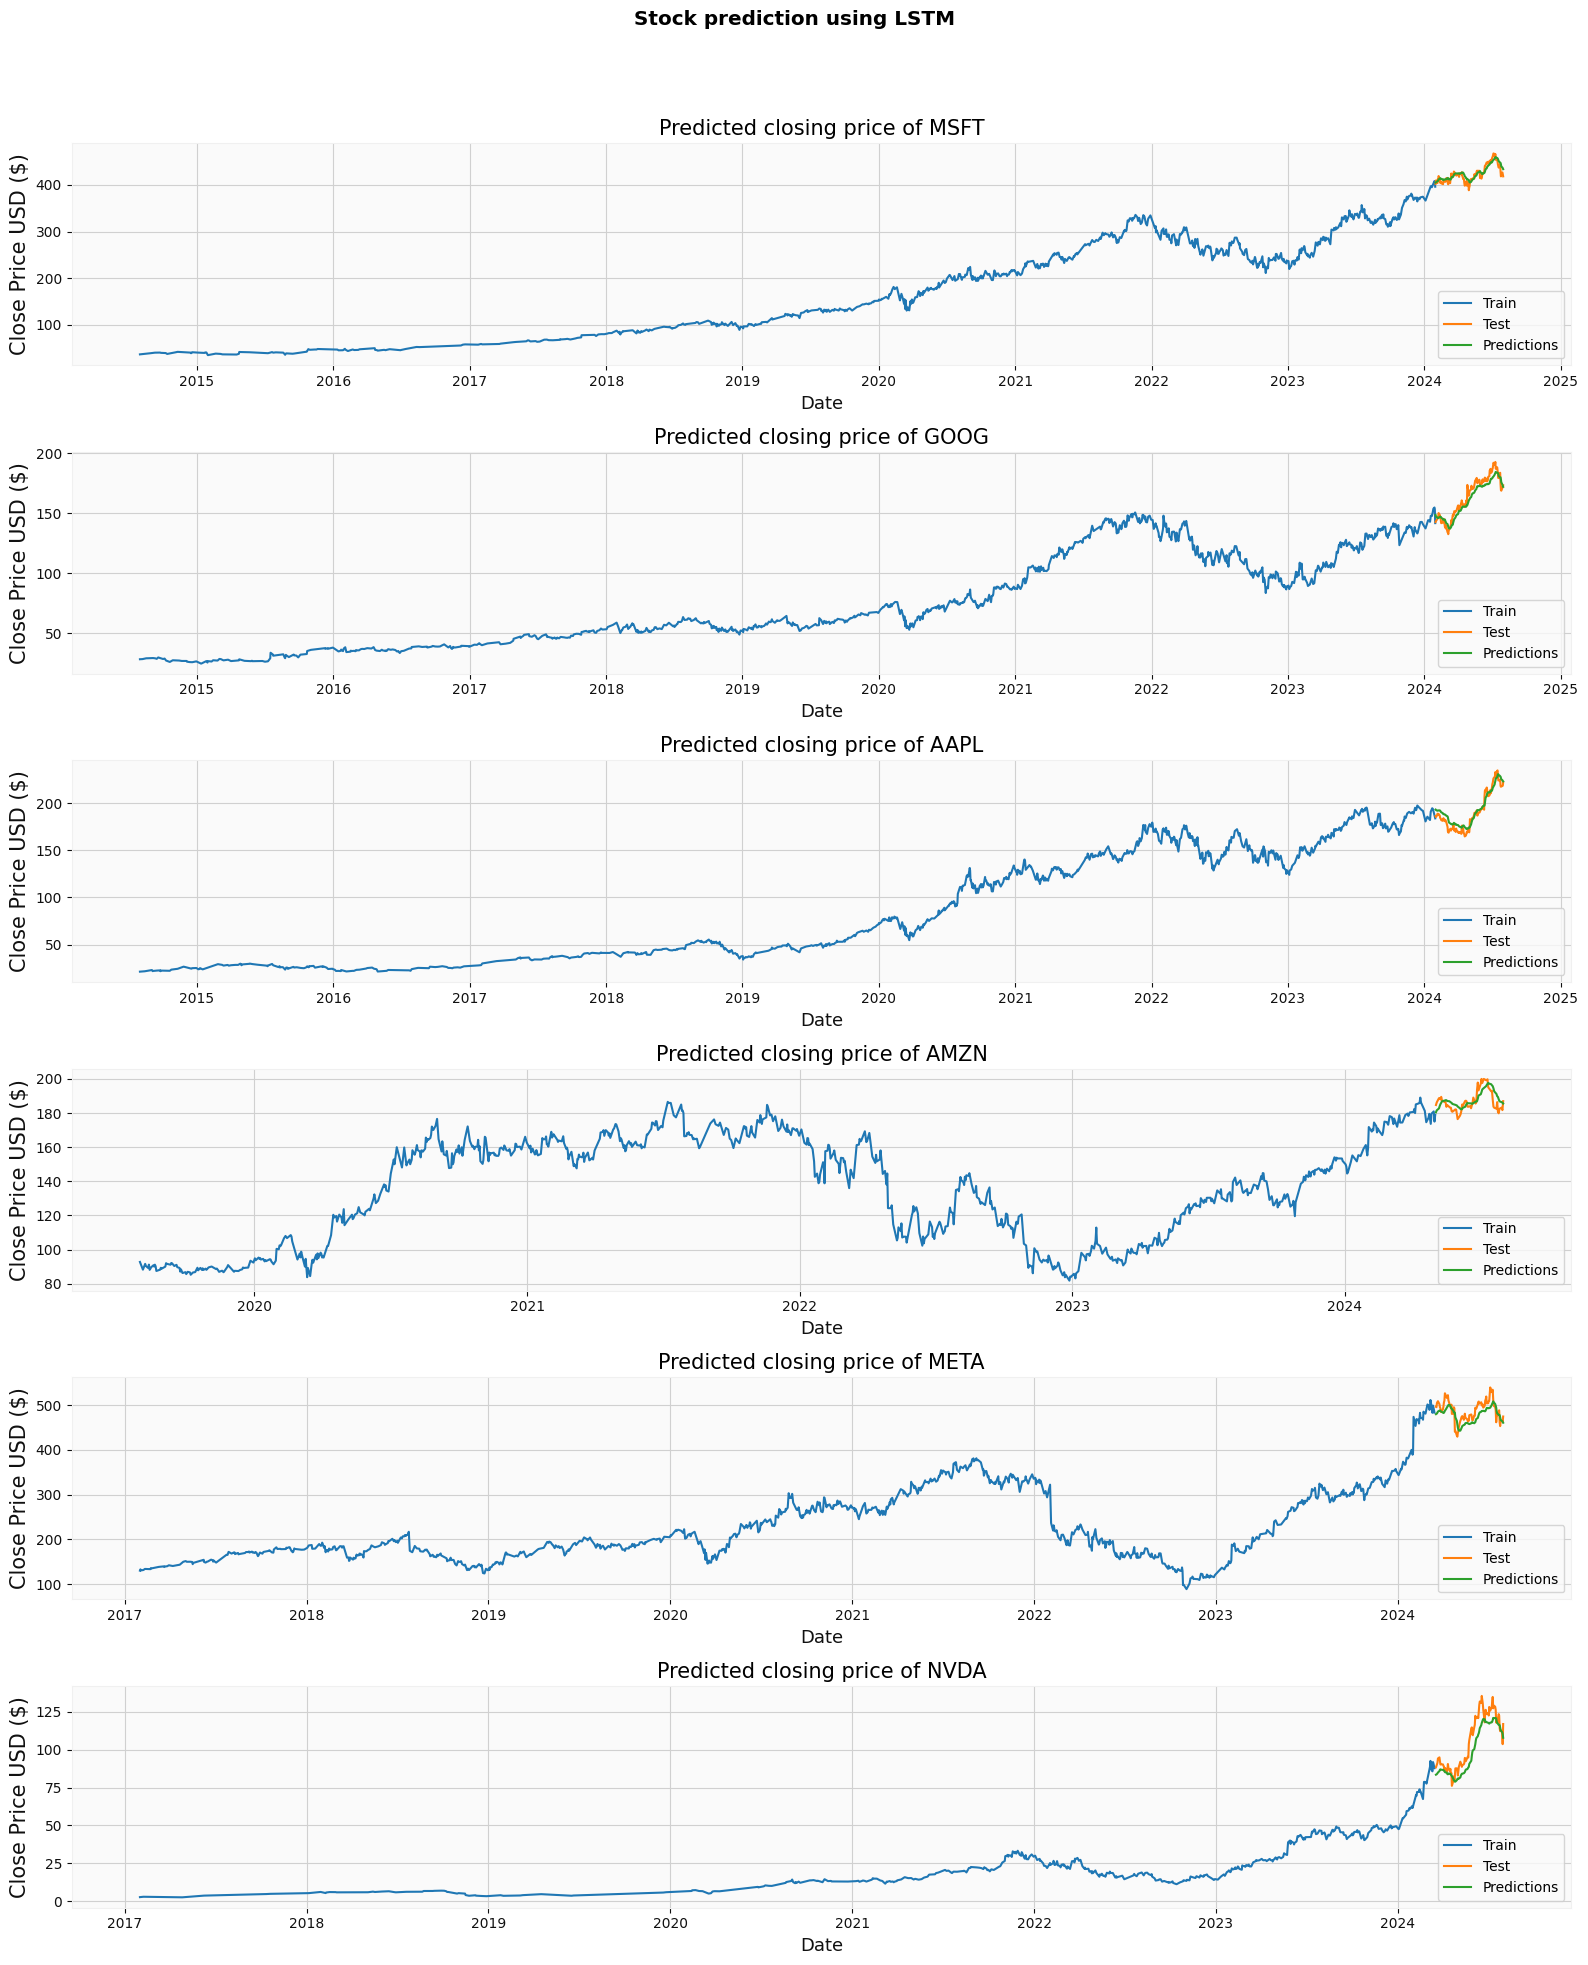

In [82]:
fig, axes = plt.subplots(len(results), 1, figsize=(16, 20))
fig.suptitle('Stock prediction using LSTM')

for idx, (i, j) in enumerate(results.items()):
    ax = axes[idx]

    #Plotting the predictions
    ax.set_title(f'Predicted closing price of {i}', size=15)
    ax.set_xlabel('Date', fontsize=13)
    ax.set_ylabel('Close Price USD ($)', fontsize=15)
    
    j["data_test"].index = j["data_test"]["Date"]
    j["data_train"].index = j["data_train"]["Date"]

    ax.plot(j["data_train"]['Close'])
    ax.plot(j["data_test"][['Close', 'Predictions']])
    ax.legend(['Train', 'Test', 'Predictions'], loc='lower right')

    print(f"Stock: {i}, RMSE(Root Mean Squared Error) : {j['error']}, Best model: {j['best_model']}")

print("Best model - 0.5, 0.75 and 1 represent size of dataset in percentages. 10, 50 and 200 represent window size of ema.")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

ARIMA, SARIMA - model training and testing

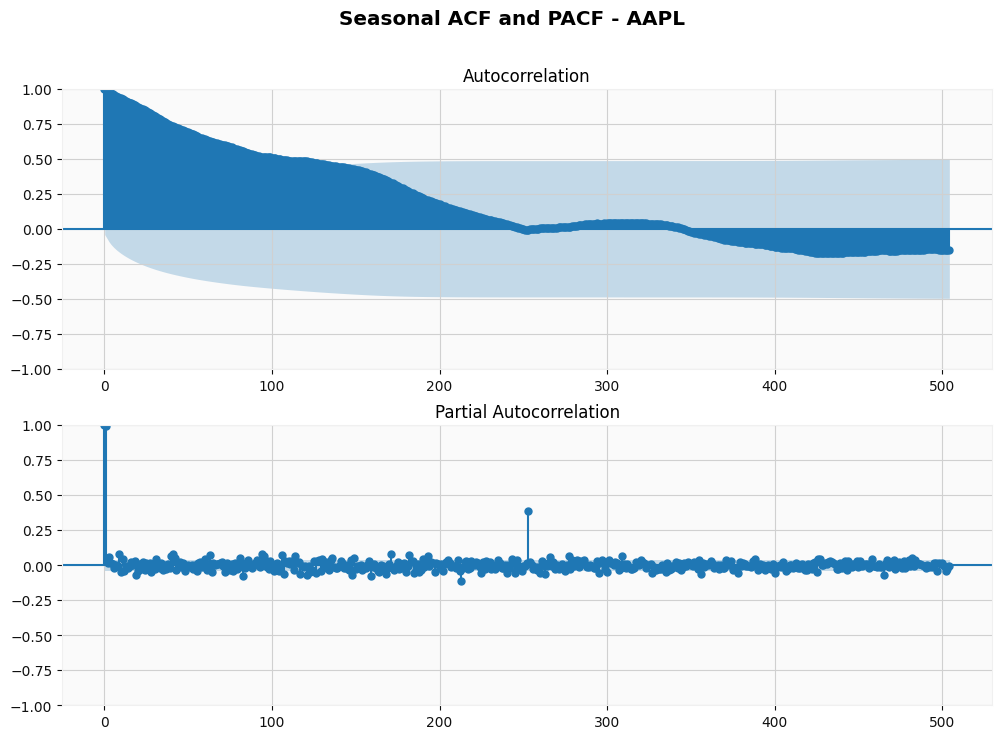

In [83]:
S = 252
a = df['Close']["AAPL"].diff(S).dropna()
fig, ax = plt.subplots(2, figsize=(12, 8))
fig.suptitle('Seasonal ACF and PACF - AAPL')
plot_acf(a.dropna(), lags=2*S, ax=ax[0])
plot_pacf(a.dropna(), lags=2*S, ax=ax[1])
plt.show()

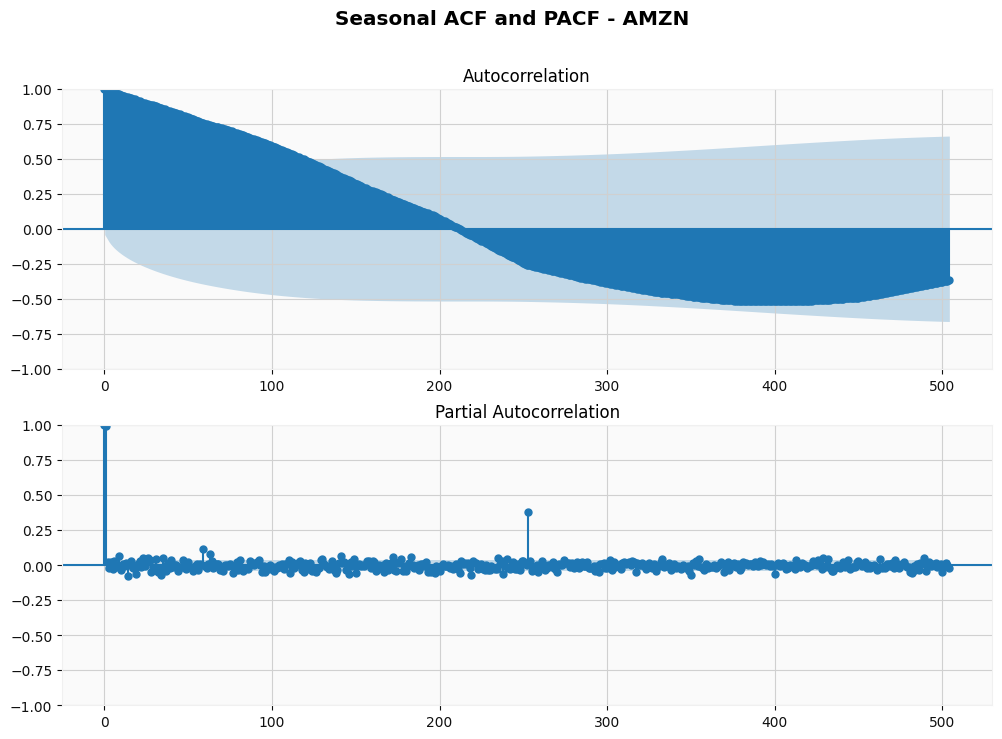

In [84]:
S = 252
a = df['Close']["AMZN"].diff(S).dropna()
fig, ax = plt.subplots(2, figsize=(12, 8))
fig.suptitle('Seasonal ACF and PACF - AMZN')
plot_acf(a.dropna(), lags=2*S, ax=ax[0])
plot_pacf(a.dropna(), lags=2*S, ax=ax[1])
plt.show()

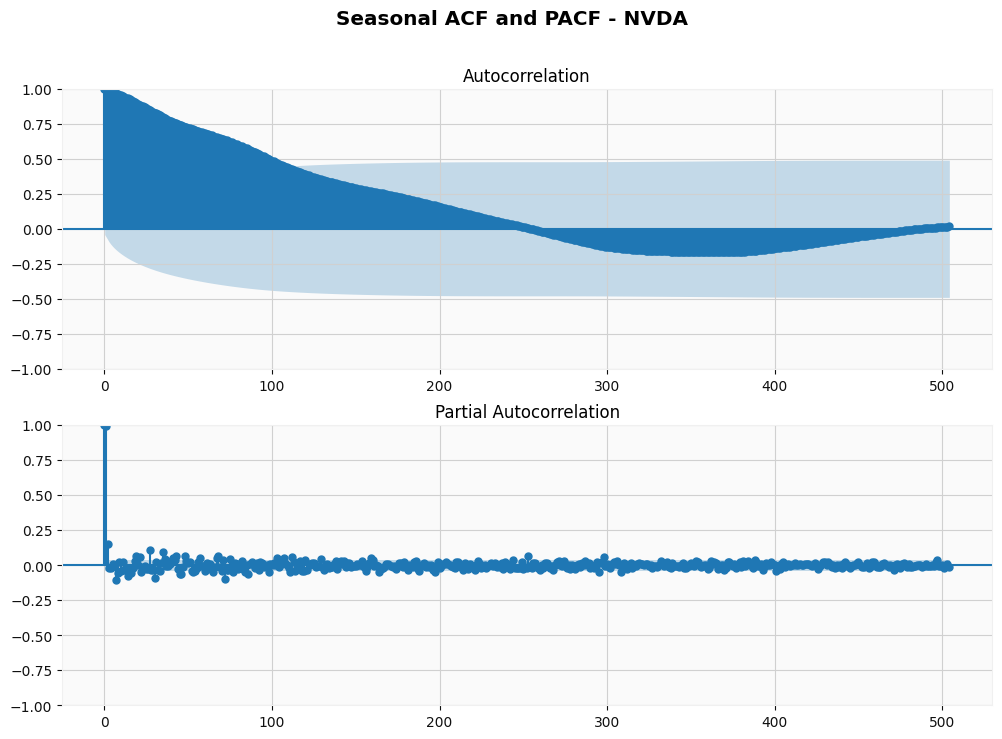

In [85]:
S = 252
a = df['Close']["NVDA"].diff(S).dropna()
fig, ax = plt.subplots(2, figsize=(12, 8))
fig.suptitle('Seasonal ACF and PACF - NVDA')
plot_acf(a.dropna(), lags=2*S, ax=ax[0])
plot_pacf(a.dropna(), lags=2*S, ax=ax[1])
plt.show()

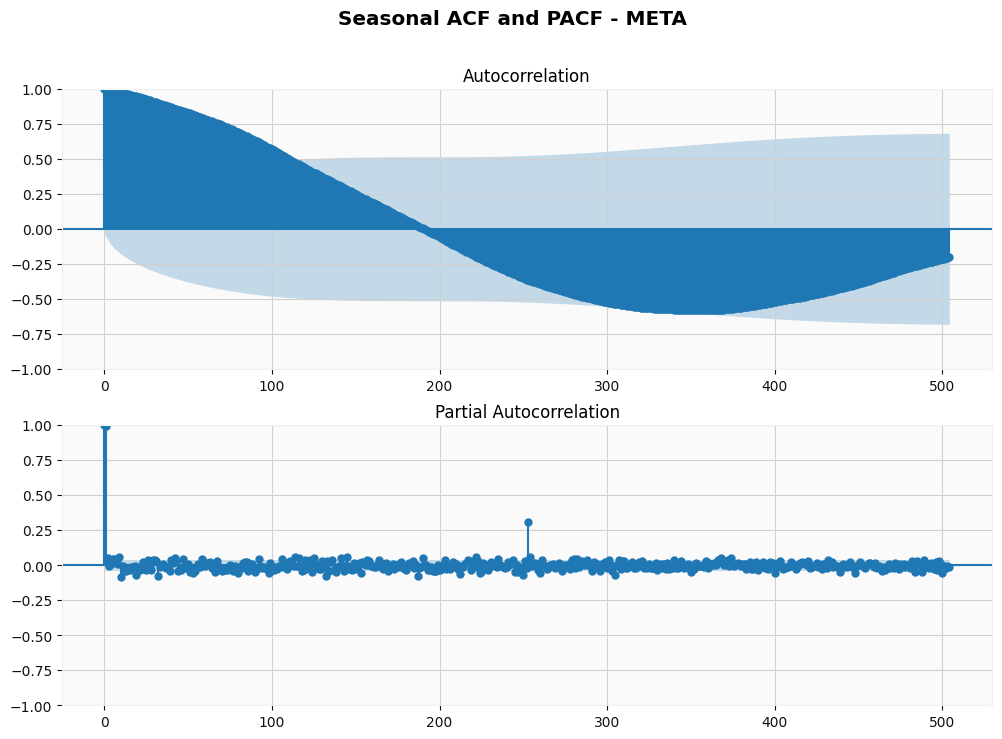

In [86]:
S = 252
a = df['Close']["META"].diff(S).dropna()
fig, ax = plt.subplots(2, figsize=(12, 8))
fig.suptitle('Seasonal ACF and PACF - META')
plot_acf(a.dropna(), lags=2*S, ax=ax[0])
plot_pacf(a.dropna(), lags=2*S, ax=ax[1])
plt.show()

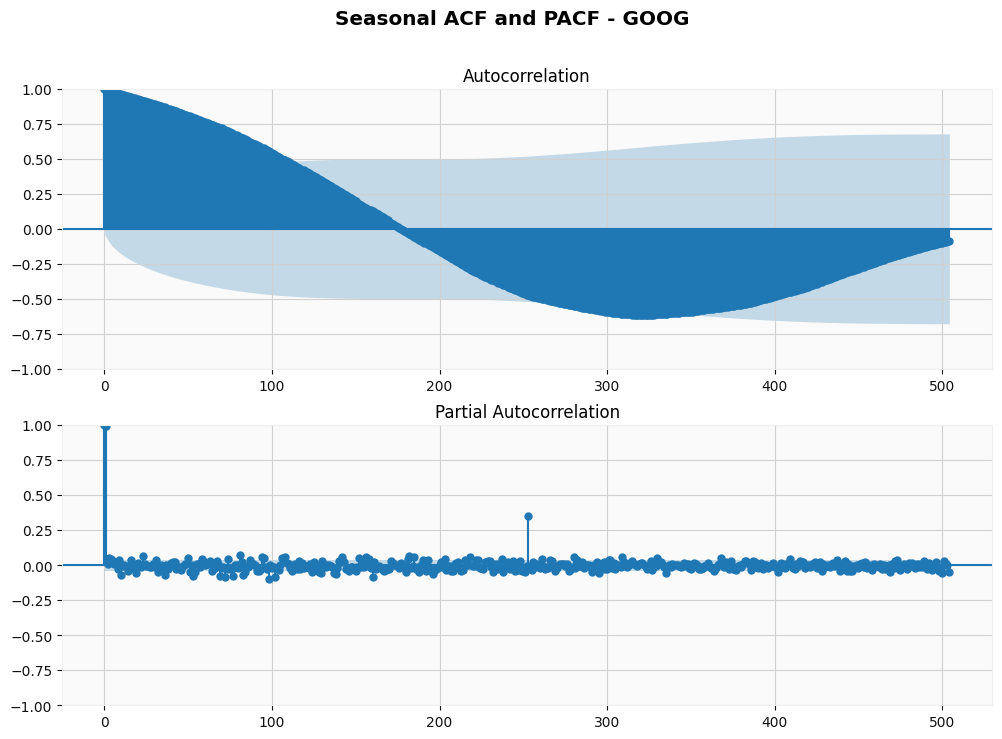

In [87]:
S = 252
a = df['Close']["GOOG"].diff(S).dropna()
fig, ax = plt.subplots(2, figsize=(12, 8))
fig.suptitle('Seasonal ACF and PACF - GOOG')
plot_acf(a.dropna(), lags=2*S, ax=ax[0])
plot_pacf(a.dropna(), lags=2*S, ax=ax[1])
plt.show()

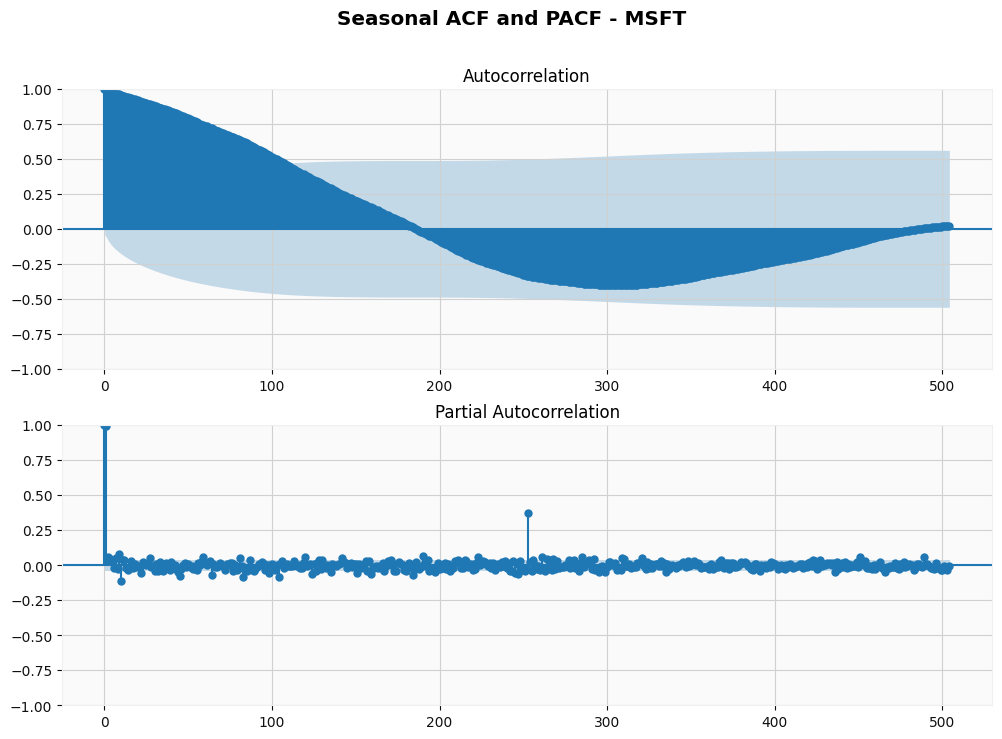

In [88]:
S = 252
a = df['Close']["MSFT"].diff(S).dropna()
fig, ax = plt.subplots(2, figsize=(12, 8))
fig.suptitle('Seasonal ACF and PACF - MSFT')
plot_acf(a.dropna(), lags=2*S, ax=ax[0])
plot_pacf(a.dropna(), lags=2*S, ax=ax[1])
plt.show()

ARIMA

Stock: MSFT, RMSE(Root Mean Squared Error) : 3.3730393155263014
Stock: GOOG, RMSE(Root Mean Squared Error) : 1.6859216573839695
Stock: AAPL, RMSE(Root Mean Squared Error) : 1.8800550206382844
Stock: AMZN, RMSE(Root Mean Squared Error) : 2.2139198414155383
Stock: META, RMSE(Root Mean Squared Error) : 5.570393320121617
Stock: NVDA, RMSE(Root Mean Squared Error) : 0.8911756749935873


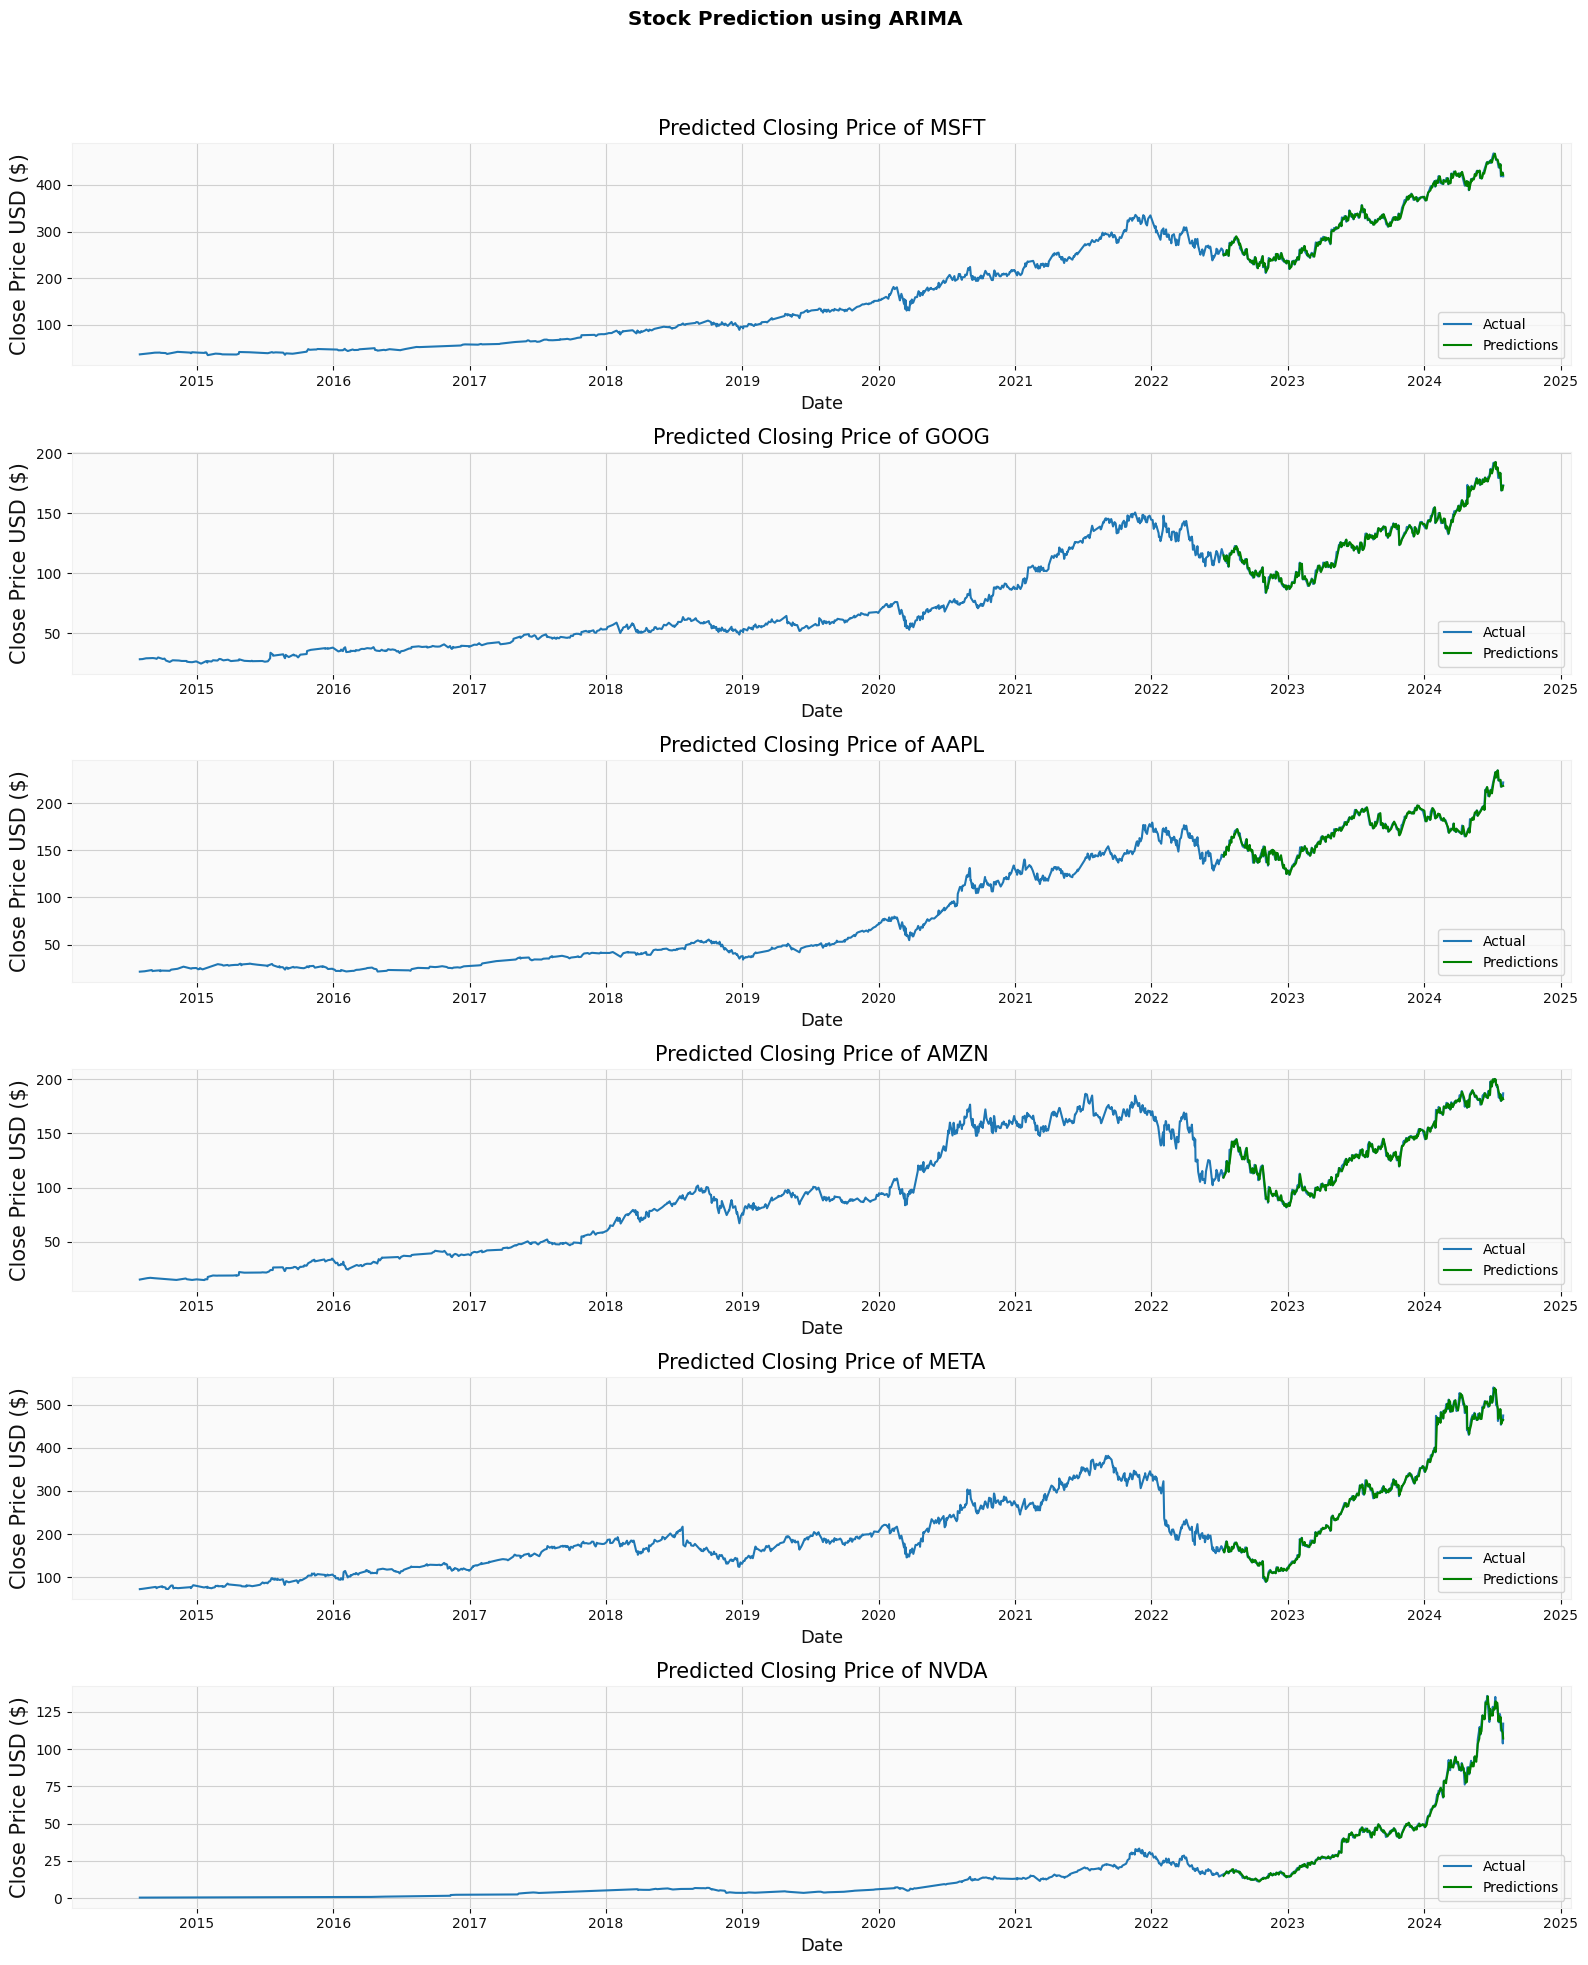

In [89]:
fig, axes = plt.subplots(len(names), 1, figsize=(16, 20))
fig.suptitle('Stock Prediction using ARIMA')

for idx, stock in enumerate(names):
    ax = axes[idx]
    
    temp = df.copy()
    model = ARIMA(temp["Close"][stock], order=(5, 1, 10))
    fitted_model = model.fit()
    
    # Make predictions
    temp[f'Predictions_{stock}'] = fitted_model.predict(start=df.index[0], end=df.index[-1])
    
    # Plotting the predictions
    ax.set_title(f'Predicted Closing Price of {stock}', size=15)
    ax.set_xlabel('Date', fontsize=13)
    ax.set_ylabel('Close Price USD ($)', fontsize=15)
    
    ax.plot(df.index, temp["Close"][stock], label='Actual')
    ax.plot(df.index[2000:], temp[f'Predictions_{stock}'][2000:], label='Predictions', color='green')

    print(f"Stock: {stock}, RMSE(Root Mean Squared Error) : {mean_squared_error(temp['Close'][stock], temp[f'Predictions_{stock}'], squared=False)}")
    
    ax.legend(loc='lower right')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


SARIMA

Stock: MSFT, RMSE (Root Mean Squared Error): 3.396650575298678
Stock: GOOG, RMSE (Root Mean Squared Error): 1.7088249920699974
Stock: AAPL, RMSE (Root Mean Squared Error): 1.8919674878394654
Stock: AMZN, RMSE (Root Mean Squared Error): 2.2240585941294886
Stock: META, RMSE (Root Mean Squared Error): 5.624631941458265
Stock: NVDA, RMSE (Root Mean Squared Error): 0.898233241628014


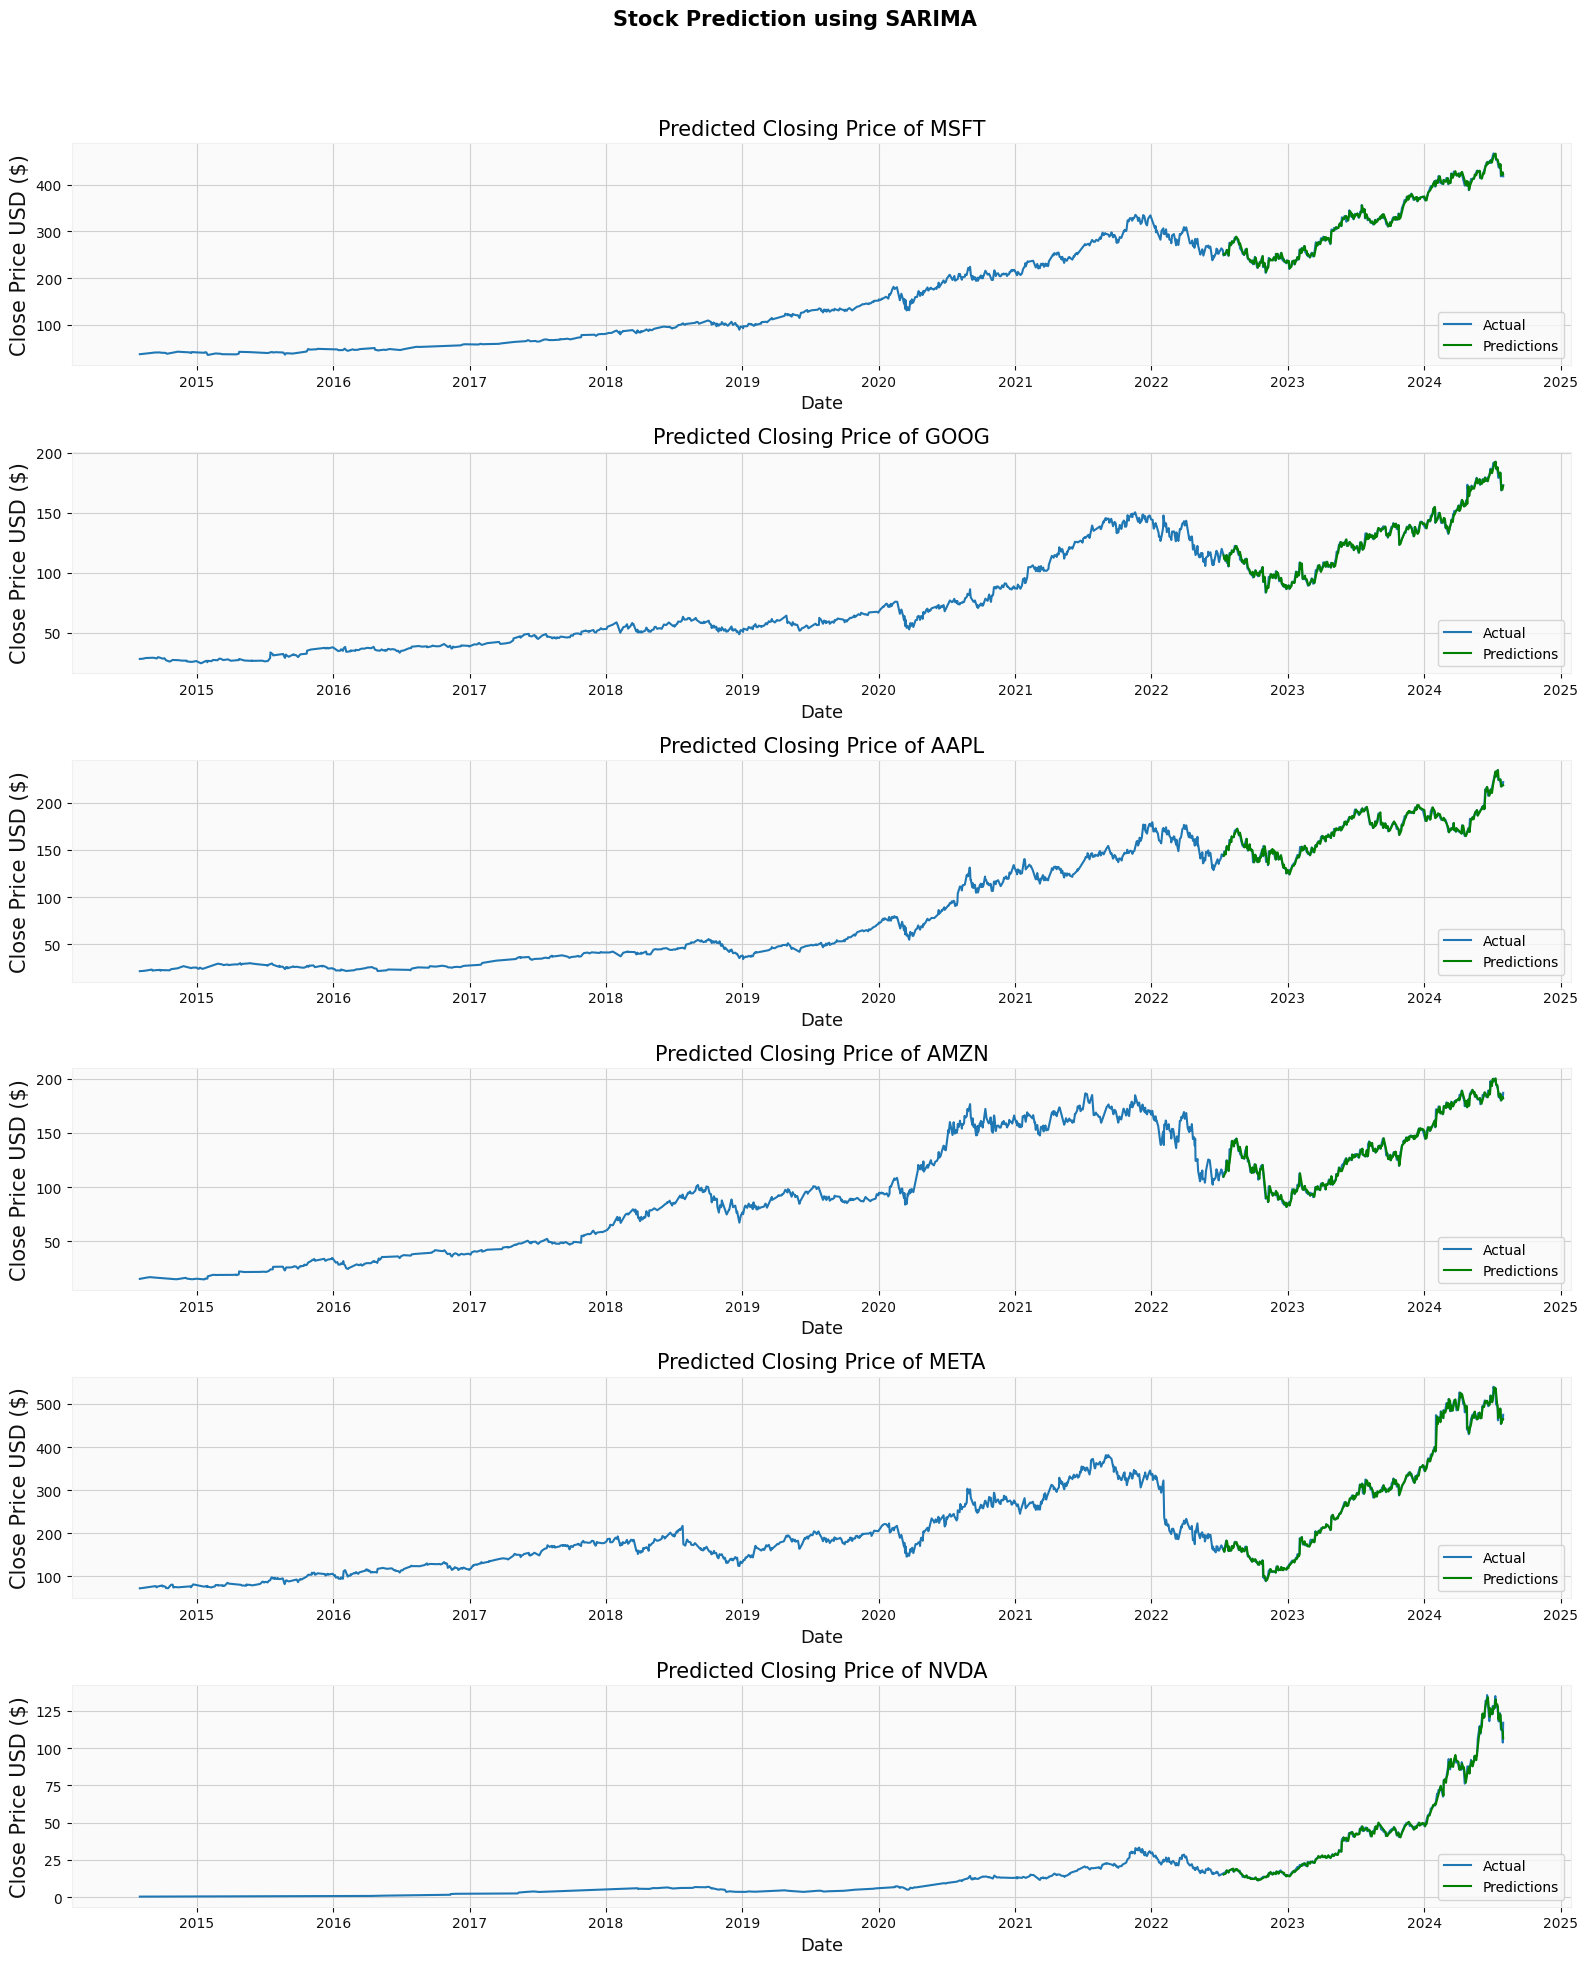

In [91]:
fig, axes = plt.subplots(len(names), 1, figsize=(16, 20))
fig.suptitle('Stock Prediction using SARIMA', fontsize=15)

for idx, stock in enumerate(names):
    ax = axes[idx]
    
    temp = df.copy()
    model = SARIMAX(temp["Close"][stock], order=(5, 1, 10), seasonal_order=(1, 1, 1, 12))
    fitted_model = model.fit()
    
    # Make predictions
    temp[f'Predictions_{stock}'] = fitted_model.predict(start=temp.index[0], end=temp.index[-1])

    # Plotting the predictions
    ax.set_title(f'Predicted Closing Price of {stock}', size=15)
    ax.set_xlabel('Date', fontsize=13)
    ax.set_ylabel('Close Price USD ($)', fontsize=15)
    
    ax.plot(temp.index, temp["Close"][stock], label='Actual')
    ax.plot(temp.index[2000:], temp[f'Predictions_{stock}'][2000:], label='Predictions', color='green')

    print(f"Stock: {stock}, RMSE (Root Mean Squared Error): {mean_squared_error(temp['Close'][stock], temp[f'Predictions_{stock}'], squared=False)}")
    
    ax.legend(loc='lower right')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


From the above, it is evident that SARIMA and ARIMA outeperform LSTM in terms of RMSE. SARIMA and ARIMA have almost equal performace as seasonality in stock market is present but the impact is very less. As SARIMA has slightly better performace than ARIMA, for prediction, SARIMA model is being used.

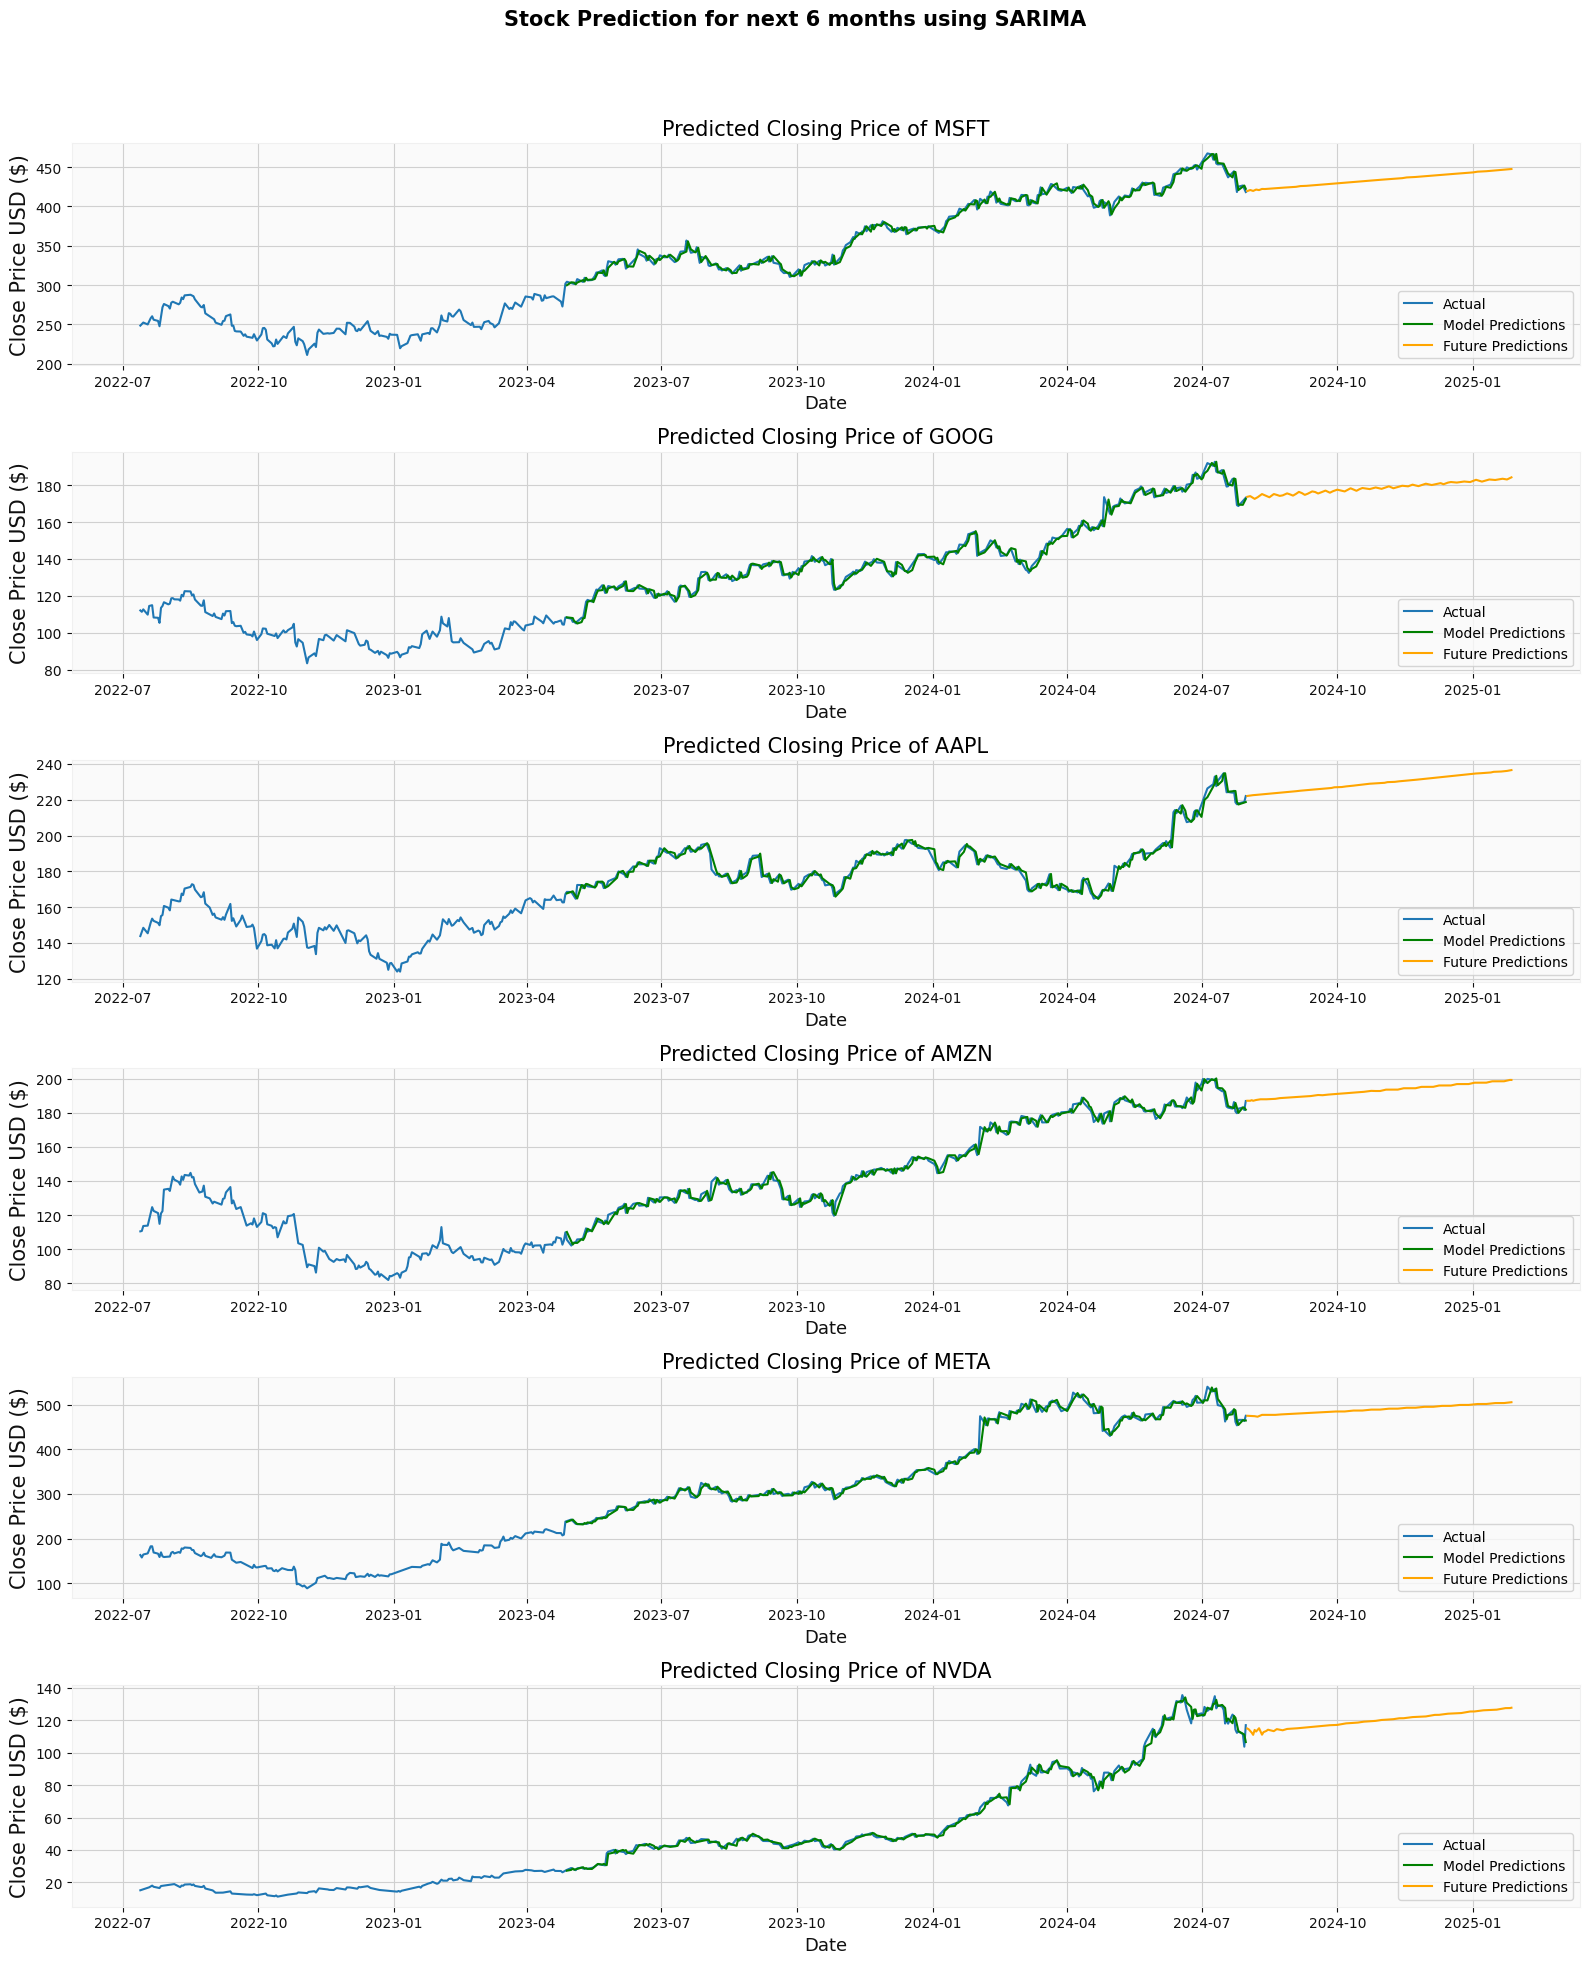

In [93]:
fig, axes = plt.subplots(len(names), 1, figsize=(16, 20))
fig.suptitle('Stock Prediction for next 6 months using SARIMA', fontsize=15)

# Next 6 months prediction
forecast_steps = 180

for idx, stock in enumerate(names):
    ax = axes[idx]
    
    temp = df.copy()
    model = SARIMAX(temp["Close"][stock], order=(5, 1, 10), seasonal_order=(1, 1, 1, 12))
    fitted_model = model.fit()
    
    # Make predictions
    temp[f'Predictions_{stock}'] = fitted_model.predict(start=temp.index[0], end=temp.index[-1])

    # Forecast the next 6 months
    forecast = fitted_model.get_forecast(steps=forecast_steps)
    forecast_index = pd.date_range(start=temp.index[-1] + pd.Timedelta(days=1), periods=forecast_steps)
    temp_forecast = pd.Series(forecast.predicted_mean.values, index=forecast_index)
    
    # Plotting the predictions
    ax.set_title(f'Predicted Closing Price of {stock}', size=15)
    ax.set_xlabel('Date', fontsize=13)
    ax.set_ylabel('Close Price USD ($)', fontsize=15)
    
    ax.plot(temp.index[2000:], temp["Close"][stock][2000:], label='Actual')
    ax.plot(temp.index[2200:], temp[f'Predictions_{stock}'][2200:], label='Model Predictions', color='green')
    ax.plot(temp_forecast.index, temp_forecast, label='Future Predictions', color='orange')
    
    ax.legend(loc='lower right')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

From the above analysis, the follwoing are the predictions by the SARIMA model:
|Company|Current price|Forecasted price in the net 6 months|Percentage increase|
|----------|---------------|-------------------------------|-------------------------|
|Amazon |181.92|199.38| 9.59|
|Google|172.49| 184.21 |6.79|
|Nvidia| 106.58|127.76|19.88|
|Microsoft|422.46|447.7 |5.97|
|Meta| 464.37|505.27|8.81|
|Apple| 218.73|236.57|8.86|

From this, we can infer that: 
- Nvidia has the highest return possibility.
- Amazon, Meta and Apple have moderate returns.
- Google and Microsoft have low returns.                                                                                                                              

This also confirms the previous expected returns graph. However the risks associated with the low return companies are low comapred to high return ones.